**Какая задача решалась:**   
Решалась задача speech enhancement, которая стремится улучшить качество аудиозаписи (убрать шумы, сделать речь более разборчивой)

**Данные:**      
Для сверки со статьей использовался датасет, выбранный в статье, который есть в общем доступе по ссылке https://datashare.is.ed.ac.uk/handle/10283/1942.
В датасете содержатся чистые и зашумленные аудиозаписи, результаты на котором можно сравнивать с остальными моделями.

In [0]:
import os
import torch
os.chdir('/content/drive/My Drive/Colab Notebooks/Vk_MetricGan/')
from utils import AudioDataset

train_dataset = AudioDataset('/content/drive/My Drive/clean_trainset_wav', '/content/drive/My Drive/noisy_trainset_wav')
val_dataset = AudioDataset('/content/drive/My Drive/clean_testset_resampled_wav', '/content/drive/My Drive/noisy_testset_resampled_wav')

In [0]:
from torch.utils.data.dataloader import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=1)

***Об архитектуре MetricGan'a:***

Из того, что это GAN следует то, что здесь есть генератор и дискриминатор)
Задача генератора в данной задача состоит в том, чтобы по спектрограмме предсказывать такую маску к ней, чтобы получить максимальное значение выбранной нами метрики (я проводил эксперименты с STOI).

Задача же дискриминатора заключается в том, чтобы выучить эту самую метрику, смотря на пары clean, denoised спектрограмм.


Генератор состоит из двух слоев BLSTM с величиной hidden state = 200, а также MLP, через которые прогоняются эти hidden state'ы. Конечной функцией активации является сигмода. Затем в полученной маске оставляют значения, которые больше 0.05, а те которые меньше делают равными 0.05.


Дискриминатор же состоит из ряда двумерных сверток, со спектральной нормализацией, т.к авторы статьи утверждают, что для данной задачи полезно иметь функцию (дискриминатор), которая имеет константу Липшица < 1.(Что обеспечивается спектральной нормализацией)


**Основной "фишкой" MetricGan'a является то, что он может выучить почти любую метрику, которая сравнивает обычную спектрограмму и измененную.**

**Так же основным отличием от обычных ганов, используемых для этой задачи, является то, что дискриминатор предсказывает не дискретное значение 0-1, а непрерывное, что позволяет подавать генератору хорошие градиенты**

Их реализации можно посмотреть в файле networks.py, а самого MetricGan'а в файле MetricGan.py


***О тренировке:***

Авторы предлагают обучать генератор и дискриминатор порциями по 100 трейн сэмплов с батчем 1. Т.е 100 итераций обучения для генератора, затем 200 итераций обучения дискриминатора (1 на паре одинаковых чистых аудиозаписей, 1 на паре чистой аудиозаписи и исправленной) и тд.

Несмотря на то, что это GAN, беты для оптимизатора были выбраны стандартные, но исходя из здравого смысла, плохо обученный дискриминатор на первых шагах может увести генератор на первых не туда, поэтому я все же поставил beta1 = 0.5 для генератора, качество от этого не упало, даже наоборот немного поднялось.

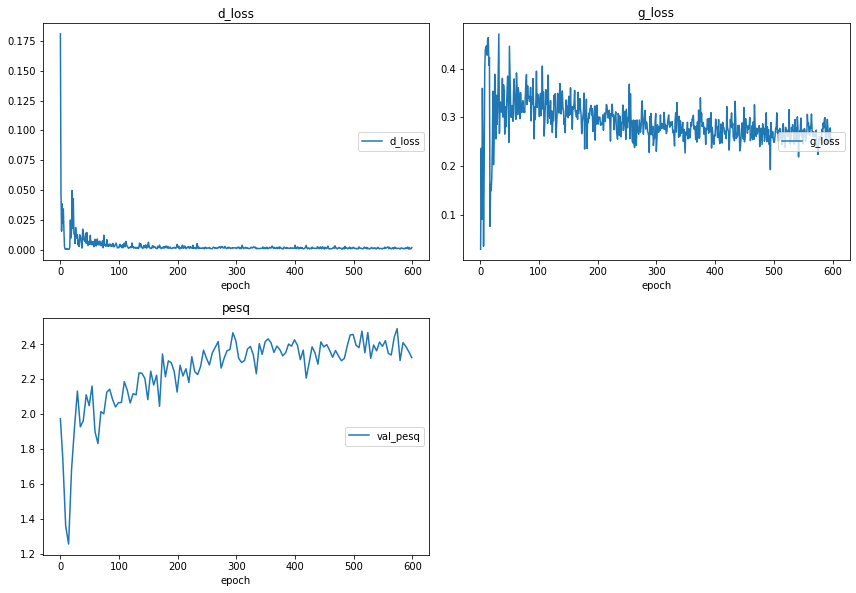

d_loss
	d_loss           	 (min:    0.000, max:    0.181, cur:    0.002)
g_loss
	g_loss           	 (min:    0.029, max:    0.471, cur:    0.248)
pesq
	val_pesq         	 (min:    1.258, max:    2.490, cur:    2.325)


In [6]:
import torch
from livelossplot import PlotLosses
from MetricGan import MetricGan
from livelossplot import PlotLosses
import random 
import copy
import time

model = MetricGan(257, 200, 2, 300, "pesq", device=torch.device("cuda:0"))
#model.load_state_dict(torch.load('/content/drive/My Drive/best_gan_checkp.pt'))
optimizer_g = torch.optim.Adam(model.G.parameters(), betas=[0.9, 0.999], lr=0.001)
optimizer_d = torch.optim.Adam(model.D.parameters(), lr=0.001)
epochs = 600
liveloss = PlotLosses()
val_best = 0.0
for epoch in range(epochs):
    logs = {}
    running_loss_g = 0.0
    running_loss_d = 0.0

    model.train()
    for idx, batch in enumerate(train_dataloader):
        if idx < 100:
            if epoch == 0:
                continue
            else:
                optimizer_g.zero_grad()
                loss_g = model.backward_G(batch)
                #print("Ground truth")
                running_loss_g += loss_g
                optimizer_g.step()
        elif idx >= 100 and idx < 200:

            optimizer_d.zero_grad()
            loss_d = model.backward_D(batch)
            running_loss_d += loss_d
            optimizer_d.step()

            batch["clean_clean"] = True

            optimizer_d.zero_grad()
            loss_d = model.backward_D(batch)
            running_loss_d += loss_d
            optimizer_d.step()            
                
        else:
            break


        if idx % 50 == 49:
            print(idx + 1)

    if epoch > 0:
        logs["g_loss"] = running_loss_g / 100

    logs["d_loss"] = running_loss_d / 200
    if (epoch + 1) % 5 == 0 or epoch == 0:
        logs, val_best = validation_metrics(model, val_dataloader, logs, val_best)
    liveloss.update(logs)
    liveloss.send()



**Результат:**  
Пытались натренировать сетку, которая оптимизирует метрику pesq на данном датасете.

Как видно - максимум, который достигается на тесте (мы валидируемся на тесте) получается - 2.5, что достаточно далеко от чисел в статье, но можно предположить, что такая разница исходит из того, что могут быть разные имплементации метрики pesq.

Несмотря на то, что не получилось приблизиться к результатам из статьи, при проверке на рандомной зашумленной записи, результаты получились достаточно приемливые.


**Перспективы:**   
Видно, что генератору не хватает обобщающей способности, чтобы прямо хорошо сойтись, возможно нужно подумать в этом направлении, к тому же если думать о продакшн решении, то лучше было бы, если генератор тоже был на свертках, т.к они лучше конвертятся и оптимизируются.
Также кажется немного странным, что первая бета Адама равна 0.9, а не 0.5, как обычно в ганах.

Возможно, также стоит попробовать отойти от идеи использования ганов для этой задачи, посмотрев вторую предложенную статью по этой теме я увидел, что результаты там получились значительно лучше этой.

***Результаты:***    
Результаты для датасета, созданного из TIMIT, используя различные шумы.
Т.к в статье не совсем четко прописано используемое количество валидационных примеров, результаты немного отличаются, но видно, что по абсолютной разницы минимума и максимума STOI результаты примерно одинаковые.
Оптимизируя метрику STOI получились очень близкие к статье результаты.
Смотреть нужно на STOI на валидации (val_stoi)
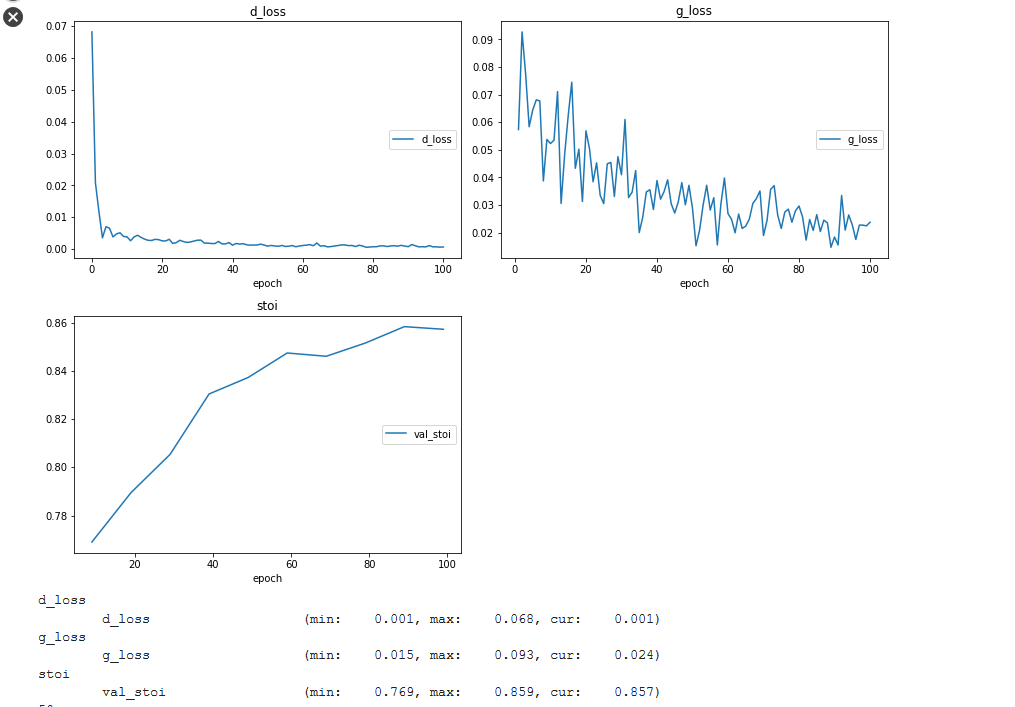

Пример из валидирующего (тестового набора)

Посмотрим на отличие с чистой wav'кой и очищенной с помощью MetricGan'а   
Также посмотрим на полученные спектрограммы:
Зашумленную, очищенную с помощью MetricGan'a

Используется чекопинт, полученный при обучении модели на первом датасете, с оптимизацией метрики pesq.


In [9]:
%matplotlib inline
from MetricGan import MetricGan
from utils import enchance_wav
from IPython.display import Audio
import soundfile as sf

model = MetricGan(257, 200, 2, 300, "pesq", device=torch.device("cuda:0"))
model.load_state_dict(torch.load('/content/drive/My Drive/best_gan_checkp_pesq.pt'))
model.eval()

sr = 16000
orig, enchanced, _, _ = enchance_wav(model, "/content/drive/My Drive/test_noisy_wavs/FAKS0_SA1/snr_12_noise_park_2_resampled.wav")
Audio(data=orig, rate=sr)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [10]:
Audio(data=enchanced, rate=sr)

In [11]:
orig, enchanced, new_spectr, old_spectr = enchance_wav(model, "/content/drive/My Drive/test_noisy_wavs/FAKS0_SA1/snr_0_noise_park_2_resampled.wav")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


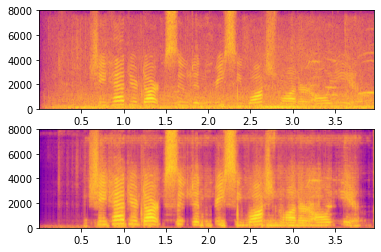

In [12]:
import matplotlib.pyplot as plt


f, (first, second) = plt.subplots(2, 1)
first.specgram(orig, Fs=16000, cmap="plasma")[3]
second.specgram(enchanced, Fs=16000, cmap="plasma")[3]

In [0]:
!cd /content/drive/My\ Drive/Colab\ Notebooks/Vk_MetricGan/ && git add MetricGan.py Vk.ipynb networks.py utils.py

In [0]:
!git config — global user.email AverageName
!git config — global user.name “Username”

In [0]:
!cd /content/drive/My\ Drive/Colab\ Notebooks/Vk_MetricGan/ && git remote rm origin 